# Deep Convolution Generative Adversarial Network (DCGAN)

This solution was inspired by the solution developed in:

https://medium.com/@manoharmanok/implementing-dcgan-in-pytorch-using-the-celeba-dataset-a-comprehensive-guide-660e6e8e29d2

https://arxiv.org/pdf/1511.06434v2.pdf


In [40]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import CelebA
from torch.utils.data import DataLoader, Subset
from torchvision.utils import make_grid
import torch.optim as optim
import math

import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if not torch.cuda.is_available():
    print("WARNING: CUDA not available. Running on CPU.")

In [3]:
# Set up variables
image_size = 64         # Desired size of input images, to match the GAN generated one
batch_size = 128        # Batch size during training
num_samples = 1000     # Number of samples to train on
batch_num = 1271

In [4]:
# Normalise data
transform_train = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
# Create train data
train_data = CelebA(root='C:/Users/Jacqu/Downloads/data/celeba', 
                    split='train', download=False, transform=transform_train)

Create a random subset of data so that we can ensure our model works before moving onto the full dataset:

In [6]:
# # Create random indices for train and test datasets
# train_indices = torch.randperm(len(train_data))[:num_samples]

# # Create random subset of data
# train_data = Subset(train_data, train_indices)

# print(f"Num Train Subset Samples: {len(train_data)}")

In [7]:
# Create DataLoader for train and test datasets
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

To make sure this worked, let's show a random set of images from the dataloader:

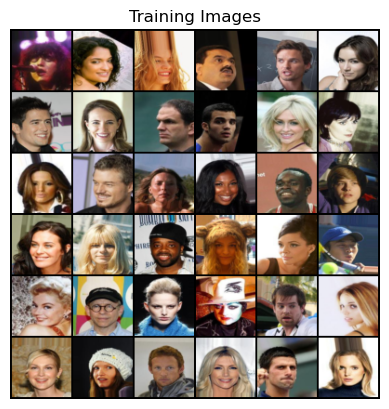

In [8]:
# Get a random batch of images
sample_batch = next(iter(train_loader))

# Make grid from the batch and normalise the images
# Need to permute since PyTorch tensors assume image channel is first dimensions
# but matplotlib assumes it is the third dimension
grid = vutils.make_grid(sample_batch[0][:36], normalize=True, nrow=6).permute(1,2,0)

plt.axis("off")
plt.title("Training Images")

# Convert to numpy array and plot
plt.imshow(np.array(grid))

## How a GAN works:

![Alt text](image-1.png)

So, the architecture of a GAN consists of two main components: the generator and the discriminator.

### The Generator
The generator takes random noise as input and gradually transforms it into fake images that resembles the training data. It does this through a series of layers, including:
- Transposed convolutions
- Batch normalisation
- Activation functions
These layers allow the generator to learn complex patterns and structures, resulting in it - over a number of epochs - being able to generate samples that capture the details of real data.

### The Discriminator
The discriminator acts as a binary classifier, all it needs to do is distinguish between real and generated samples. Similar to the generator, it receives input samples and passes them through:
- Convolutional layers
- Batch normalisation
- Activation functions
It's role is essentially just assessing the authenticity of samples and provide feedback (in terms of loss) to the generator.

Through an adversarial training process, these two models continuously compete and improve their performance, leading to the generation of better and more realistic samples.

In [9]:
# Hyperparameters
learning_rate = 0.0001  # Learning rate for model during optimisation (adjusted from recommended 0.0002)
image_channels = 3      # Number of channels in input images (3 for RGB)
z_dim = 100             # Size of z latent space (i.e. size of generator input)
num_epochs = 10         # Number of training epochs
features_disc = 64      # Number of features in discriminator's convolutional layers
features_gen = 64       # Number of features in generator's convolutional layers

## Generator Network

The Generator architecture I followed looked like this:

![Alt text](image-10.png)

So, the input noise data, represented as a 100x1x1 tensor, undergoes a series of transposed convolutional operations to transform it into an output image of size 3x64x64 (RGB colour, with a standard size of 64).

By passing the noise data through these transposed convolutional layers, the generator gradually upscales the low-dim noise into high-dim image to match desired output.

The reshaping process involves increasing spatial dimensions while reducing the number of channels.

In [10]:
class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, num_features_gen):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            self._block(z_dim, num_features_gen * 16, 4, 1, 0), # output: [num_features_gen * 16, 4, 4]
            self._block(num_features_gen * 16, num_features_gen * 8, 4, 2, 1), # output: [num_features_gen * 8, 8, 8]
            self._block(num_features_gen * 8, num_features_gen * 4, 4, 2, 1), # output: [num_features_gen * 4, 16, 16]
            self._block(num_features_gen * 4, num_features_gen * 2, 4, 2, 1), # output: [num_features_gen * 2, 32, 32]
            # self._block(num_features_gen * 2, num_features_gen * 2, 4, 1, 1), # output: [num_features_gen * 2, 32, 32]
            nn.ConvTranspose2d(
                num_features_gen * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            nn.Tanh()
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.net(x)

The structure of the Generator model is:

1. Input noise: 100x1x1
2. First transposed convolutional layer:
    - Output size: 1024x4x4
    - Kernel size: 4x4, stride: 1, padding: 0
3. Second transposed convolutional layer:
    - Output size: 512x8x8
    - Kernel size: 4x4, stride: 2, padding: 1
4. Third transposed convolutional layer:
    - Output size: 256x16x16
    - Kernel size: 4x4, stride: 2, padding: 1
5. Fourth transposed convolutional layer:
    - Output size: 128x32x32
    - Kernel size: 4x4, stride: 2, padding: 1
6. Final transposed convolutional layer:
    - Output size: 3x64x64
    - Kernel size: 4x4, stride: 2, padding: 1


The Generator class represents the generator network in the DCGAN architecture. It takes as input:
- z_dim: dimension of the latent space
- channels_img: number of channels in the output image
- num_features_gen: number of features for the generator

This network is a sequential model, which is just a linearly stacked set of layers that directly input and output to the layer before/after it.

Each sequential layer does the following:
- Transposed convolutional layer
- Batch normalisation
- ReLU activation function

Note that the ReLU activation function is used to add non-linearity to the model to push the model to essentially be able to create more complex images.
Note also that transposed convolutional layers allow for upsampling, increasing the spatial dimensions of the output (compared to regular, which downsamples).

The last sequential layer involves just a transposed convolutional layer.

After these sequential blocks are computed, then the output image is passed through a specific type of activation function called a "hyperbolic tangent activation function", so that the pixel values are within the range [-1, 1].

In the forward function, the input noise is just passed through the sequential layers to eventually become a generated image.

Notes:
- nn.Tanh is used as it:
    - Helps the generated image match the distribution of the real image.
    - Assists in the stability during training (especially since GANs can go a bit wild with convergence)
- sigmoid will normalise images between [0, 1]
- tanh will normalise images between [-1, 1]

## Discriminator Network

The Discriminator architecture I followed looked like this:

![Alt text](image-11.png)

The Discriminator takes an input image (3x64x64, same as the generated and real images) and processes
it through a series of convolutional layers, resulting in a 1x1x1 output.

The model gradually reduces the spatial dimensions while increasing the number of channels. This allows
it to evaluate the image to determine whether it's real or not.

The 1x1x1 output is a single value that represents the probability of the input image being real or fake.

In [11]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, num_features_disc):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(channels_img, num_features_disc, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            self._block(num_features_disc, num_features_disc * 2, 4, 2, 1),
            self._block(num_features_disc * 2, num_features_disc * 4, 4, 2, 1),
            self._block(num_features_disc * 4, num_features_disc * 8, 4, 2, 1),
            nn.Conv2d(num_features_disc * 8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid()
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)   # negative slope of 0.2, just a slightly increased slope compared to default
        )

    def forward(self, x):
        return self.disc(x)

The reshaping process for the Discriminator network is:
1. Input image: 3x64x64
2. First convolutional layer:
    - Output size: 64x32x32
    - Kernel size: 4x4, stride: 2, padding: 1
3. Second convolutional layer:
    - Output size: 128x16x16
    - Kernel size: 4x4, stride: 2, padding: 1
4. Third convolutional layer:
    - Output size: 256x8x8
    - Kernel size: 4x4, stride: 2, padding: 1
5. Fourth convolutional layer:
    - Output size: 512x4x4
    - Kernel size: 4x4, stride: 2, padding: 1
6. Final convolutional layer:
    - Output size: 1x1x1
    - Kernel size: 4x4, stride: 2, padding: 0

The Discriminator class represents the discriminator network in the DCGAN architecture. It takes as input:
- channels_img: number of channels in the input image
- num_features_disc: number of features for the discriminator

This network is also a sequential model, which is just a linearly stacked set of layers that directly input and output to the layer before/after it.

The first layer is a conv. layer, followed by a leaky ReLU activation fucntion, to allow a small gradient for negative values (this can help the gradient flow through the network).

The intermediate layers do the following:
- Convolutional layer
- Batch normalisation
- Leaky ReLU activation function

After these sequential layers have been computed, the final conv. layer uses a sigmoid activation function. This squashes the output between the range [0, 1], essentially classifying the input
image as real (close to 1) or fake (close to 0).

## Initialising weights

The initialisation method used was the one recommended by the original DCGAN paper. We iterate through
the layers of the model and initialise the weights based on the layer type.
- Convolutional: Initialise the weights with a mean of 0 and standard devation of 0.02
- Batch Norm: Initialise weights with a mean of 1 and a standard deviation of 0.02, set bias to 0

In [12]:
# The following initialisation method was developed using the original DCGAN paper and ChatGPT.
def initialise_weights(model):
    classname = model.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

## Initialisation of Models

Now, we initialise our models with our parameters defined earlier and send them to the GPU.
We then initialise the weights of the models with our previous function.

In [13]:
generator = Generator(z_dim, image_channels, features_gen).to(device)
discriminator = Discriminator(image_channels, features_disc).to(device)

initialise_weights(generator)
initialise_weights(discriminator)

Following the DCGAN paper again, the Adam optimiser was used for both models with the
recommended learning rate of 0.0002 (as defined previously). Additionally, the beta_1 momentum term
was reduced to 0.5 as suggested by the paper. The default value of 0.9 was said to have resulted in
training oscillation.

Next, the Binary Cross Entropy Loss function was used to compare the predictions of the Discriminator
with the true labels. This was used due to the commonality of the function within GANs.

Lastly, some random noise was created to act as the input noise for the generator during training.

In [14]:
opt_gen = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
opt_disc = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
criterion = nn.BCELoss()

fixed_noise = torch.randn(32, z_dim, 1, 1).to(device)

The following is a utility function that takes a tensor of images, normalises them, creates a grid
of images and displays them using matplotlib:

In [43]:
# the following function was taken directly from the DCGAN tutorial notebook as it was seen
# to be a utility function.
def show_tensor_images(image_tensor, num_images=32, size=(1, 64, 64)):
    image_tensor = (image_tensor + 1) / 2  # Unnormalize the image
    image_unflat = image_tensor.detach().cpu()  # Detach and move to CPU

    # Calculate the number of rows needed for the number of images
    nrow = math.ceil(math.sqrt(num_images))

    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)  # Make the grid
    
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())  # Rearrange dimensions and plot
    plt.axis("off")
    plt.show()

## Training the model

Finally, we train our model:

Epoch [1/10] Batch 1271/1272                     Loss D: 1.3661, loss G: 2.2089


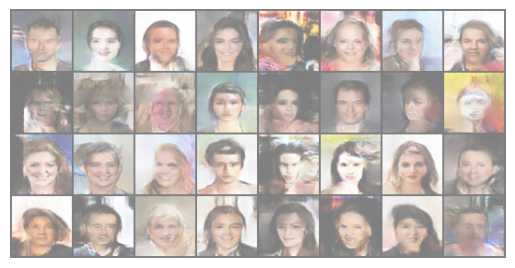

Epoch [2/10] Batch 1271/1272                     Loss D: 0.3623, loss G: 5.1160


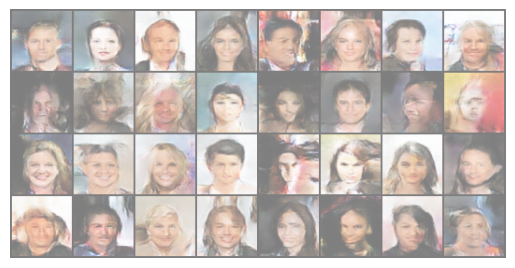

Epoch [3/10] Batch 1271/1272                     Loss D: 0.0399, loss G: 4.3340


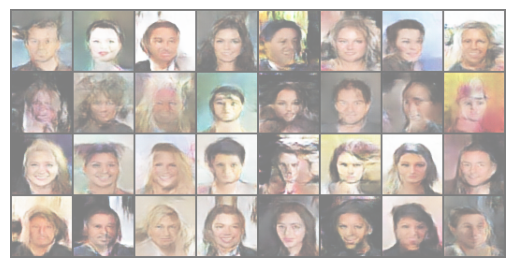

Epoch [4/10] Batch 1271/1272                     Loss D: 0.0465, loss G: 3.9776


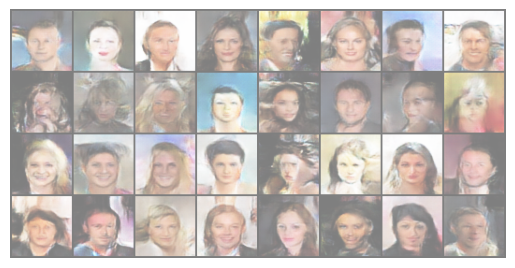

Epoch [5/10] Batch 1271/1272                     Loss D: 0.3455, loss G: 4.1245


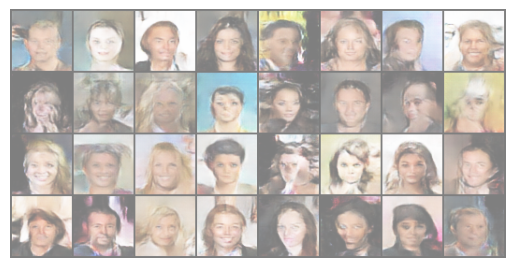

Epoch [6/10] Batch 1271/1272                     Loss D: 0.2835, loss G: 2.3964


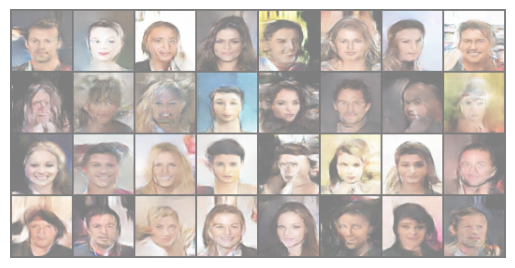

Epoch [7/10] Batch 1271/1272                     Loss D: 0.0296, loss G: 6.1671


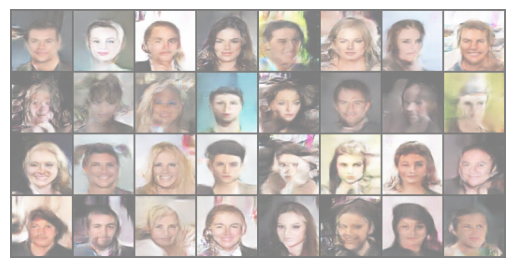

Epoch [8/10] Batch 1271/1272                     Loss D: 0.2417, loss G: 3.1721


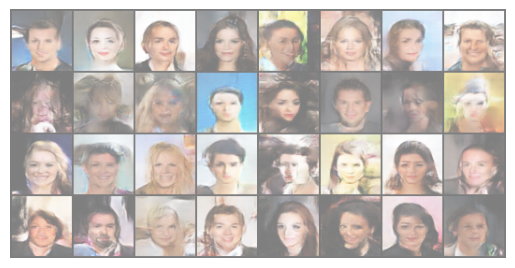

Epoch [9/10] Batch 1271/1272                     Loss D: 0.0449, loss G: 3.4351


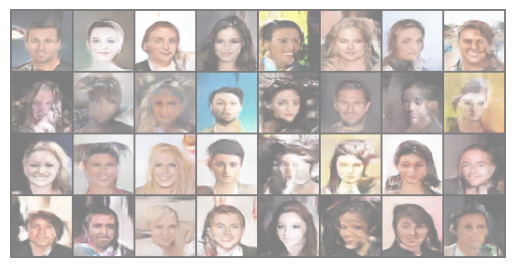

Epoch [10/10] Batch 1271/1272                     Loss D: 0.3294, loss G: 6.1687


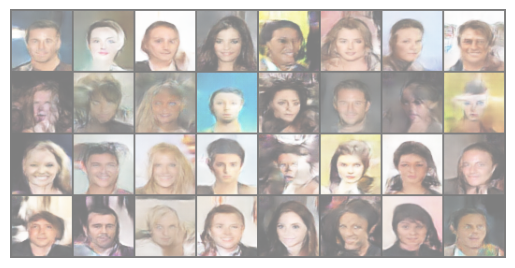

In [18]:
generator.train()
discriminator.train()

for epoch in range(1, num_epochs+1):
    for batch_idx, (real_im, _ ) in enumerate(train_loader):
        real_im = real_im.to(device)

        # 1. Noise generation and create fake image
        noise = torch.randn((batch_size, z_dim, 1, 1)).to(device)
        fake_im = generator(noise)

        # 2. Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        # 2.1 Calculate loss on all-real batch
        disc_real = discriminator(real_im).reshape(-1) # reshape to 1D vector
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))

        # 2.2 Calculate loss on all-fake batch
        fake_im = generator(noise)
        disc_fake = discriminator(fake_im.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))

        # 2.3 Calculate average discriminator loss
        loss_disc = (loss_disc_real + loss_disc_fake) / 2

        # 2.4 Backprop and optimise discriminator
        discriminator.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        # 3. Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        # 3.1 Calculate loss on all-fake batch
        output = discriminator(fake_im).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))

        # 3.2 Backprop and optimise generator
        generator.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Print losses occasionally and fake images occasionally
        if (epoch % 1 == 0) and (batch_idx == batch_num):
            print(
                f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(train_loader)} \
                    Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}"
            )
            with torch.no_grad():
                fake_im = generator(fixed_noise)
                img_grid_fake = make_grid(fake_im[:32], normalize=True)
                show_tensor_images(img_grid_fake)

Save our model for later

In [19]:
torch.save(generator, 'gen.pth')

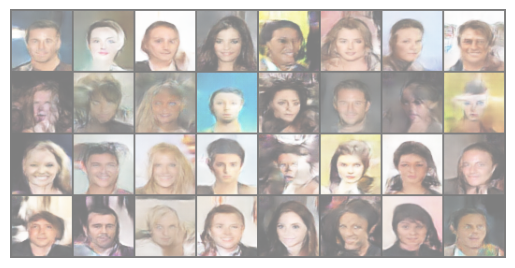

In [48]:
generator = torch.load('gen.pth')
with torch.no_grad():
    fake_im = generator(fixed_noise)
    img_grid_fake = make_grid(fake_im[:32], normalize=True)
    show_tensor_images(img_grid_fake)